In [55]:
import matplotlib.pyplot as plt
from rnpe.utils import get_manual_legend
import seaborn as sns
import pickle

sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
colors = ["#072D41", "#ECA918", "#60B3C8", "#359735"]
plt.rcParams['axes.axisbelow'] = True

fn = "../results/fraziergaussian/9.pickle"
    
with open(fn, "rb") as f:
    results = pickle.load(f)

## Plot denoised scatterplot

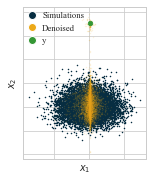

In [58]:
n = 10000
textwidth = 5.5

plt.figure(figsize=(textwidth*0.4, 2.8))

plt.scatter(
    x=results["data"]["x"][:n, 0],
    y=results["data"]["x"][:n, 1],
    color=colors[0],
    s=0.5,
    )

plt.scatter(
    x=results["mcmc_samples"]["x"][:n, 0],
    y=results["mcmc_samples"]["x"][:n, 1],
    color=colors[1],
    s=0.5,
    alpha=0.1,
    )

plt.scatter(
    x=results["data"]["y"][0],
    y=results["data"]["y"][1],
    color=colors[3],
    s=20,
    )

plt.tick_params(
    axis='both',         
    which='both',
    labelleft=False,
    labelbottom=False)

x_names = [r"$x_1$", r"$x_2$"]

plt.xlabel(x_names[0])
plt.ylabel(x_names[1])

legend = get_manual_legend(["Simulations", "Denoised", "y"], [colors[0], colors[1], colors[3]])

plt.legend(
    handles=legend,
    bbox_to_anchor=[-0.06, 1.02],
    loc="upper left",
    frameon=False,
    handletextpad=0.1)


plt.rc('axes', axisbelow=True)

plt.savefig("../results/plots/basic_example_denoised.png", dpi=400)

# plt.table(
#     rowLabels=x_names,
#     cellText=misspecified,
#     loc="upper right",
#     colWidths=[0.06])

In [59]:
print(results["mcmc_samples"]["misspecified"].mean(axis=0))

[0.42527 0.94479]


### Get true posterior

In [60]:
import numpy as np

obs_mu = results["data"]["y"][0] * results["scales"]["x_std"][0] + results["scales"]["x_mean"][0]

def gaussian_posterior_mu_std(obs_mean, p_var=25, l_var=2, n=100):
    mu = ((obs_mean*n)/l_var) * ((1/p_var + n/l_var)**(-1))
    std = np.sqrt((1/p_var + n/l_var)**(-1))
    return mu, std

mu, std = gaussian_posterior_mu_std(obs_mu)
mu = (mu - results["scales"]["x_mean"][0])/results["scales"]["x_std"][0]
std = std / results["scales"]["x_std"][0]
true_posterior_samps = np.random.normal(mu, std, (n,))

/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.2 x 1.5 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/plots/basic_example_posterior.png
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 2677 rows containing non-finite values.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 2677 rows containing non-finite values.


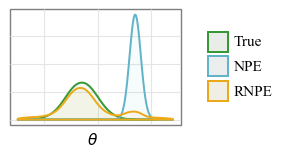

<ggplot: (8765262416104)>

In [66]:
import pandas as pd
posterior_df = pd.concat(
    [pd.DataFrame(
        {"Source": "True",
        "theta": true_posterior_samps
        }),
        pd.DataFrame({
        "Source": "RNPE",
        "theta": results["posterior_samples"]["Robust NPE"][:n, 0]
        }),
    pd.DataFrame(
        {"Source": "NPE",
        "theta": results["posterior_samples"]["NPE"][:n, 0]
        })
    ]
)

posterior_df["Source"] = pd.Categorical(posterior_df["Source"], ["True", "NPE", "RNPE"])

from plotnine import ggplot, aes, geom_density, xlim, theme_bw, scale_color_manual, scale_fill_manual, xlab, theme, element_blank, element_text, ylab
font_kwargs = {"family": "Times New Roman", "size": 11}
txt = element_text(**font_kwargs)

p = (ggplot(posterior_df, aes(x="theta", color="Source", fill="Source")) +
geom_density(alpha=0.05, size=0.8, bw=0.01) +
scale_color_manual(values=[colors[3], colors[2], colors[1]]) +
scale_fill_manual(values=[colors[3], colors[2], colors[1]]) +
theme_bw() +
xlab(r"$\theta$") +
xlim((-0.05, 0.24)) +
ylab("") +
theme(
    legend_title=element_blank(),
    text=txt,
    figure_size=(textwidth*0.4, 1.5),
    panel_grid_minor=element_blank(),
    axis_text=element_blank(),
    axis_ticks=element_blank()
)
)
p.save("../results/plots/basic_example_posterior.png", dpi=400)
p